# 자연어처리 기술을 활용한 사회 주요 이슈 분석 및 여론 예측 모델(SNU GSDS Lee yoon seop)

## import

In [ ]:
! pip install transformers
! pip install -U sentence-transformers
! pip install funcy pickle5

! sudo apt-get install -y fonts-nanum
! sudo fc-cache -fv
! rm ~/.cache/matplotlib -rf

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

# TASK 2. 클러스터링 기반 뉴스 토픽 모델링(Cluster-based News article Topic modeling)
    - 토픽모델링(Topic Modeling)은 텍스트 데이터를 구성하는 단어들의 패턴을 분석하여 문서 집합에서 주제 또는 쟁점 등을 자동으로 추출하는 비지도 학습 프로세스이다.
    - 클러스터 기반 토픽모델링은 클러스터링 아키텍처에 언어모델의 임베딩을 접목시킨 방법론이다.
    - 본 프로젝트에서는 병렬 클러스터링과 의미론적 임베딩을 활용한 토픽모델링을 구현한다.


    - Topic modeling is an unsupervised learning process that automatically extracts topics or issues from a document set by analyzing the patterns of words constituting text data.
    - Cluster-based topic modeling is a methodology that combines embedding from language models with a clustering architecture.
    - In this project, we create a topic modeling model using parallel clustering and semantic embedding.
    
    - To summarize the entire process of the 『Parallel Clustering based News article Topic Modeling』 we designed, it consists of the following four steps.
        STEP 1) Unsupervised training(TSDAE) : The language model understands the context of a given news article and optimizes it for the domain through unsupervised learning of the TSDAE method.
        STEP 2) Supervised trainig(NLI and STS) : Our language model trains on the Korean NLI·STS dataset so that the model can distinguish similarities between sentences or documents.
        STEP 3) Parallel Clustering : This clustering method we designed focuses on speed and stability.
        STEP 4) Keyword Extraction : Extracts important words from clustered groups using C-TF-IDF (Class-based Term Freq-Inverse Doc Freq) calculation method.

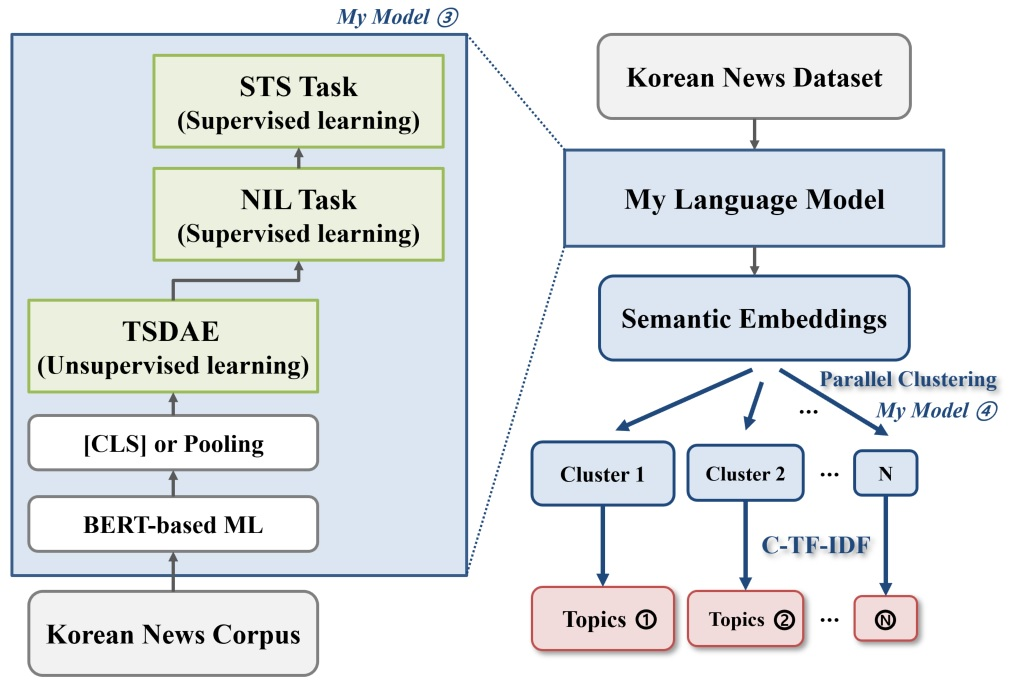

# STEP 1) 언어모델 비지도 학습(TSDAE : Transformer-based and Sequential Denosing Auto-Encoder)
    - TSDAE 비지도 학습 방법은 다음 3가지 단계로 진행된다.
        1. 입력 시퀀스(뉴스 문장) 內 토큰을 삭제 또는 교체하여 노이즈(Noise)를 생성한다.
        2. 손상된 입력 시퀀스은 트랜스포머 인코더 네트워크를 통해 문장 수준의 벡터(Sentence Embedding)로 인코딩된다.
        3. 디코더(Decoder) 네트워크는 손상된 문장 임베딩을 원래 손상 이전 입력 시퀀스로 복원ㆍ예측하며 학습한다.

    - TSDAE consists of the following three steps:
        1. TSDAE introduces noise to input sequences by deleting or swapping tokens.
        2.  These damaged sentences are encoded by the transformer model into sentence embedding.
        3. Another decoder network then attempts to reconstruct the original input from the damaged sentence encoding.

## 1-1. TSDAE 모델 디자인(My TSDAE Language model)

In [ ]:
##############################################
## 1. Korean Denoising Auto-Encoder Dataset ##
##############################################
import konlpy
from konlpy.tag import Mecab
from torch.utils.data import Dataset
from sentence_transformers.readers.InputExample import InputExample
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

class DenoisingAutoEncoderDataset(Dataset):
    def __init__(self, sentences, noise_fn = lambda sent :  DenoisingAutoEncoderDataset.delete(sent)):
        self.sentences = sentences
        self.noise_fn = noise_fn
        self.mecab = Mecab()

    def __getitem__(self, item):
        sent = self.sentences[item]
        return InputExample(texts=[self.noise_fn(sent), sent])  # label : Similar[0], texts : {Original text; Noised text}

    def __len__(self):
        return len(self.sentences)
    
    # Noise function
    @staticmethod
    def delete(text, del_ratio = 0.55): # ratio 55% is best performance
        mecab = Mecab()
        words_tok = mecab.morphs(text)
        n = len(words_tok)
        if n == 0:
            return text
        
        keep_or_not = np.random.rand(n) > del_ratio  # [False, Fasle, True, True, False, True]
        if sum(keep_or_not) == 0:                    # number of [True]
            keep_or_not[np.random.choice(n)] = True
        words_processed = " ".join(np.array(words_tok)[keep_or_not])
        return words_processed
    

#############################################
## 2. Denoising Auto-Encoder Loss Function ##
#############################################
import torch
from torch import nn, Tensor
from sentence_transformers import SentenceTransformer, models
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, models

class DenoisingAutoEncoderLoss(nn.Module):
    def __init__(self, model, decoder_name = None, tie_encoder_decoder = True):
        super(DenoisingAutoEncoderLoss, self).__init__()
        self.encoder = model
        self.tokenizer_encoder = model.tokenizer # model tokenizer

        encoder_name = model[0].auto_model.config._name_or_path       # model[0] : Transformer, model[0].auto_model : 'bert-base-uncased' / model[1] : Pooling
        
        if decoder_name == None:
            assert tie_encoder_decoder, "Must indicate the decoder_name argument when tie_encoder_decoder = False"
        if tie_encoder_decoder:
            decoder_name = encoder_name
        
        self.tokenizer_decoder = AutoTokenizer.from_pretrained(decoder_name)
        self.need_retokenization = not (type(self.tokenizer_encoder) == type(self.tokenizer_decoder))

        # Bert Config with Decoder & Cross attentions
        decoder_config = AutoConfig.from_pretrained(decoder_name)
        decoder_config.is_decoder = True
        decoder_config.add_cross_attention = True
        kwargs_decoder = {'config': decoder_config}
        # Make Decoder : LM Cross Attentions
        self.decoder = AutoModelForCausalLM.from_pretrained(decoder_name, **kwargs_decoder)
        
        # if you use GPT-2 
        if self.tokenizer_decoder.pad_token is None:
            self.tokenizer_decoder.pad_token = self.tokenizer_decoder.eos_token
            self.decoder.config.pad_token_id = self.decoder.config.eos_token_id
        
        if tie_encoder_decoder:
            if len(self.tokenizer_encoder) != len(self.tokenizer_decoder):
                self.tokenizer_decoder = self.tokenizer_encoder
                self.decoder.resize_token_embeddings(len(self.tokenizer_decoder))  # Vocab_size(30522)
            decoder_base_model_prefix = self.decoder.base_model_prefix
            PreTrainedModel._tie_encoder_decoder_weights(
                model[0].auto_model,
                self.decoder._modules[decoder_base_model_prefix],
                self.decoder.base_model_prefix
            )

    def retokenize(self, sentence_features):
        input_ids = sentence_features['input_ids']
        device = input_ids.device
        sentences_decoded = self.tokenizer_encoder.batch_decode(
            input_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )
        retokenized = self.tokenizer_decoder(
            sentences_decoded,
            padding=True,
            truncation='longest_first',
            return_tensors="pt",
            max_length=None).to(device)
        return retokenized

    def forward(self, sentence_features, labels):
        source_features, target_features = tuple(sentence_features)  # (noised text, orginal text)
        if self.need_retokenization:
            target_features = self.retokenize(target_features)

        # 1. Sentence Embedding from Encoder
        reps = self.encoder(source_features)['sentence_embedding']  # [batch_size, hidden_dim]

        target_length = target_features['input_ids'].shape[1]
        decoder_input_ids = target_features['input_ids'].clone()[:, :target_length - 1]     # Decoder Input : input - [102] token
        label_ids = target_features['input_ids'][:, 1:]                                     # Label : input - [102] token

        # 2. Sentence Embedding from Decoder : output is CausalLMOutput with Cross Attentions
        decoder_outputs = self.decoder(
            input_ids = decoder_input_ids,
            inputs_embeds = None,
            attention_mask = None,
            encoder_hidden_states = reps[:, None],  # (batch_size, hidden_dim) -> (batch_size, 1, hidden_dim)
            encoder_attention_mask = source_features['attention_mask'][:, 0:1],
            labels = None,
            return_dict = None,
            use_cache = False)  # decoder_outputs : [loss = None, logits]
        
        # 3. Calculate Loss
        lm_logits = decoder_outputs[0]  # logits : [batch_size, seq_length, vocab_size]
        ce_loss_fct = nn.CrossEntropyLoss(ignore_index = self.tokenizer_decoder.pad_token_id)
        loss = ce_loss_fct(lm_logits.view(-1, lm_logits.shape[-1]), label_ids.reshape(-1)) # CE_Loss([seq_length, vocab_size], [seq_length])
        return loss

## 1-2. 모델 사전학습 (Pretrain my language model)

In [ ]:
# 1. Load News Corpus data
file_path = "./data/korean_news_corpus.txt"
with open(file_path) as f:
    lines = f.readlines()
    sent_list = [line.rstrip('\n') for line in lines]

sent_list = [x for x in sent_list if x != 'None']
print(">> Total Number of Corpus for TSDAE training : {}".format(len(sent_list)))

>> Total Number of Corpus for TSDAE training : 1482944


In [ ]:
# 2. Examples of Denoising AutoEncoder Dataset
train_data = DenoisingAutoEncoderDataset(sent_list[:10])

for row in train_data:
    print(row)

<InputExample> label: 0, texts: 뜨거운 이 임대차 법 으로 는 새로운 이 토론 도마 위 에 같; 뜨거운 여름이 지나면 아마 임대차 3 법 으로 불리는 새로운 법이 토론의 도마 위에 오를 것 같다 
<InputExample> label: 0, texts: 법 전세 가능 만드 이;  이 법의 내용을 요약하면 4 년 전세 를 가능하게 만드는 것이다 
<InputExample> label: 0, texts: 이 되 면 는 2 후 한 더 갖;  만약 이 제도가 도입되면 세입자는 2 년 후에 전월세 계약을 한 번 더 연장할 권리를 갖게 된다 
<InputExample> label: 0, texts: 살 싶 으면 2 2 을 으면 4 동안 걱정 살 되 것 이;  2 년만 살고 싶으면 2 년 2 년을 더 살고 싶으면 4 년 동안은 전세금 올려줄 걱정 없이 살 수 있게 되는 것이다 
<InputExample> label: 0, texts: 이 법 이 세입자 매력 것 한 계약 하 은 살 으니 성 보장 된다는 점 다;  이 법이 세입자에게 매력적으로 다가오는 것은 한 번 계약하면 4 년은 살 수 있으니 주거의 안정성이 보장된다는 점이다 
<InputExample> label: 0, texts: 주 거의 이 누구 비용 으로 나오 것 인가 따져 봐야 한다;  여기서 우리는 그 주거의 안정성이 과연 누구의 비용으로 나오는 것인가를 따져봐야 한다 
<InputExample> label: 0, texts: 언뜻 주인 은 4 년 동안 내보낼 수 없 게 보이 않 는 을 의 대가 들 이 주거 안정 는 것 으로 하 그 비용 주머니;  언뜻 생각하면 집주인은 한 번 세입자를 받으면 4 년 동안 내보낼 수 없게 되므로 집주인이 보이지 않는 비용을 치르고 그 비용의 대가로 세입자들이 주거안정의 혜택을 보는 것으로 생각하기 쉽지만 사실 그 비용은 세입자의 주머니에서 나온다 
<InputExample> label: 0, texts: 사실 집 주인 굳이 원인 제공 자면 세입자 들 이

In [ ]:
# 3.TSDAE unsupervised-embeddings training 
# 3-1. Dataset with noise function
train_data = DenoisingAutoEncoderDataset(sent_list)

# 3-2. Dataloader
loader = DataLoader(
    train_data,
    batch_size = 8,
    shuffle = True, 
    drop_last = True
    )

# 3-3. Retrain or not / Save my model or not
re_train = True
save_MyModel = True

# 3-4-1. Load trained model 
if re_train:
    print("\n *** Retrain model *** \n")
    model_name = './models/news-bert/20000'
    model = SentenceTransformer(model_name)
# 3-4-2. Sentence Embedding using [CLS] token or Mean/Max Pooling
else:
    print("\n *** Pretrain model *** \n")
    model_name = 'klue/bert-base' 
    bert = models.Transformer(model_name)
    pooling = models.Pooling(bert.get_word_embedding_dimension(), 'mean') # cls, mean, max
    model = SentenceTransformer(modules = [bert, pooling])

# 3-5. Use Loss function
loss = DenoisingAutoEncoderLoss(model, tie_encoder_decoder = True)

epochs = 1      # Best epoch == 3
warmup_steps = int(len(loader) * epochs * 0.05) # Warmup 5 %

# 3-6. Train
model.fit(
    train_objectives=[(loader, loss)],
    epochs = epochs,
    warmup_steps = warmup_steps,
    checkpoint_path = './models/news-bert',
    checkpoint_save_steps = 20000,
    weight_decay = 0,  
    scheduler = 'constantlr',
    optimizer_params = {'lr': 3e-5},
    show_progress_bar = True
)
# 3-7. Save final model
if save_MyModel:
    model.save('./models/news-bert')


 *** Retrain model *** 



Some weights of BertLMHeadModel were not initialized from the model checkpoint at ./models/news-bert/20000/ and are newly initialized: ['encoder.layer.6.crossattention.output.dense.bias', 'encoder.layer.2.crossattention.self.key.bias', 'encoder.layer.4.crossattention.output.LayerNorm.weight', 'encoder.layer.8.crossattention.self.query.bias', 'encoder.layer.11.crossattention.output.dense.bias', 'encoder.layer.7.crossattention.self.query.weight', 'encoder.layer.8.crossattention.self.value.weight', 'encoder.layer.7.crossattention.self.value.bias', 'encoder.layer.1.crossattention.self.query.bias', 'encoder.layer.7.crossattention.self.key.bias', 'encoder.layer.9.crossattention.self.key.bias', 'encoder.layer.1.crossattention.output.dense.bias', 'encoder.layer.8.crossattention.self.value.bias', 'encoder.layer.3.crossattention.output.LayerNorm.weight', 'encoder.layer.4.crossattention.self.key.weight', 'encoder.layer.2.crossattention.self.query.bias', 'encoder.layer.0.crossattention.output.Laye

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/185368 [00:00<?, ?it/s]

# STEP 2) 의미론적 임베딩을 지도학습(Fine-tuning on NIL and STS dataset for designing Semantic Language Models)
    - 높은 성능의 텍스트 클러스터링과 토픽모델링을 구현하기 위해서는 좋은 의미론적 임베딩(High-quality Semantic Embedding)을 생성하는 언어모델이 중요하다.
    - 이에, 유사한 문장간 벡터 공간에서 가까워지도록 미세조정하는 NLI(Natural Language Inference)과 STS(Semantic Textual Similarity) 2가지 지도학습을 추가로 수행한다.

    - In order to implement high-performance text clustering and topic modeling, a language model that generates high-quality semantic embeddings is important.
    - Accordingly, two types of supervised learning are additionally performed: Natural Language Inference (NLI) and Semantic Textual Similarity (STS), which fine-tune the vector space between similar sentences.

## 2-1. Sentence-BERT 기반 모델 디자인(My Sentence-BERT language model)

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel 
from torch import nn
import json
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, models, SentenceTransformer, SentencesDataset, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
import math

def make_sentenceBERT(model_path, tokenizer_path):
    # 1. Load KoLawBERT
    word_embedding_model = models.Transformer(model_name_or_path = model_path,
                                              tokenizer_name_or_path = tokenizer_path)
    
    # 2. Mean pooling to get one fixed sized sentence vector
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                   pooling_mode_mean_tokens=True,
                                   pooling_mode_cls_token=False,
                                   pooling_mode_max_tokens=False)
    
    # 3. Sentence-BERT
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    return model

# Make KorNLI Dataset for Training
def drop_kornli(df):
    df = df.dropna(how='any')
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

def make_kornli_dataset(df):
    label_dict = {"contradiction": 0, "entailment": 1, "neutral": 2}
    samples = []
    s1 = df['sentence1'].to_list()
    s2 = df['sentence2'].to_list()
    label = list(map(lambda x : label_dict[x], df['gold_label'].to_list()))
    for (s1, s2, score) in zip(s1, s2, label):
        samples.append(InputExample(texts= [s1,s2], label=score))
    return samples

def drop_korsts(df):
    df = df.dropna(how='any')
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    df = df.loc[:,['score', 'sentence1', 'sentence2']]
    return df

def make_korsts_dataset(df):
    samples = []
    s1 = df['sentence1'].to_list()
    s2 = df['sentence2'].to_list()
    score = list(map(lambda i : i/5.0, df['score'].to_list()))
    for (s1, s2, score) in zip(s1, s2, score):
        samples.append(InputExample(texts= [s1,s2], label=score))
    return samples

## 2-2. NLI Fine-Tuning Task

In [ ]:
# Load Language models
model_path = './models/news-bert'
model = SentenceTransformer(model_path)

In [ ]:
##############################
## 1. NIL Task Fine-Tuning  ##
##############################

# Load dataset
train_snli = pd.read_csv("data/snli_1.0_train.ko.tsv", sep='\t', quoting=3)  
train_xnli = pd.read_csv("data/multinli.train.ko.tsv", sep='\t', quoting=3)
train_data = pd.concat([train_snli, train_xnli], ignore_index=True)
print(">> Total Train Dataset size :", len(train_data))

# Dataset for Eval
val_data = pd.read_csv("data/sts-dev.tsv", sep='\t', quoting=3)
test_data = pd.read_csv("data/sts-test.tsv", sep='\t', quoting=3)
print(">> Total Validataion Dataset size :", len(val_data))
print(">> Total Test Dataset size :", len(test_data))

# label_dict
label_dict = {"contradiction": 0, "entailment": 1, "neutral": 2}

train_data = drop_kornli(train_data)
train_data.head()

>> Total Train Dataset size : 942854
>> Total Validataion Dataset size : 1500
>> Total Test Dataset size : 1379


,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [ ]:
# Make Dataset for Training
# Traing dataset
train_batch_size = 16
train_samples = make_kornli_dataset(train_data)

# Train DataLoader
train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

# Val/Test dataset
val_data = drop_korsts(val_data)
test_data = drop_korsts(test_data)

dev_samples = make_korsts_dataset(val_data)
test_samples = make_korsts_dataset(test_data)

# Eval DataLoader
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='sts-dev')

# Loss function : Calculate MSE loss
train_loss = losses.SoftmaxLoss(model=model,
                                sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                num_labels=len(label_dict))

# Warmup(10% of train data for warm-up) & Epochs
num_epochs = 3
warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) # 10%
model_save_path = './models/nil_news-bert'

In [ ]:
# Training
model.fit(train_objectives = [(train_dataloader, train_loss)],
          evaluator = dev_evaluator,
          epochs = num_epochs,
          evaluation_steps = 1000,
          warmup_steps = warmup_steps,
          output_path = model_save_path)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58864 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58864 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58864 [00:00<?, ?it/s]

## 2-3. STS Fine-Tuning Task

In [ ]:
##############################
## 2. STS Task Fine-Tuning  ##
##############################

# 1. Load dataset
train_batch_size = 16
train_data = pd.read_csv("data/sts-train.tsv", sep='\t', quoting=3)
val_data = pd.read_csv("data/sts-dev.tsv", sep='\t', quoting=3)
test_data = pd.read_csv("data/sts-test.tsv", sep='\t', quoting=3)

train_data = drop_korsts(train_data)
val_data = drop_korsts(val_data)
test_data = drop_korsts(test_data)

#  2. Make Dataset for STS Task Training
train_samples = make_korsts_dataset(train_data)
dev_samples = make_korsts_dataset(val_data)
test_samples = make_korsts_dataset(test_data)

# 2-1. DataLoader
train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

# 2-3. Loss function : Calculate Cosine similarity
train_loss = losses.CosineSimilarityLoss(model=model)

# 2-4. Evaluator 
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

# 2-5. Warmup(10% of train data for warm-up) & Epochs
model_save_path = './models/nil_sts_news-bert'
num_epochs = 15
warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1)  

In [ ]:
# 3. Training
model.fit(train_objectives = [(train_dataloader, train_loss)],
          evaluator = evaluator,
          epochs = num_epochs,
          evaluation_steps = 1000,
          warmup_steps = warmup_steps,
          output_path = model_save_path)

In [ ]:
# 4. Evaluation
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
print(">> Best TEST Socre is : {:.4f}".format(test_evaluator(model, output_path=model_save_path)))

>> Best TEST Socre is : 0.7774


# STEP 3 & 4. 병렬 클러스터링 기반 주요 뉴스 키워드 추출(Parallel Clustering-based Topic modeling with PLMs)

## 3-1. 병렬 클러스터링 기반 토픽 모델링 디자인(My Parallel Clustering-based Topic Modeling)
    - 클러스터 기반 토픽 모델링이란? 텍스트 임베딩을 클러스터 프레임워크에 적용하여 키워드를 추출하는 방법론이다.
    - 우리는 빠르고, 심플한 클러스터링 기반 토픽모델링을 디자인 하였다.
        1. 병렬 클러스터링을 통해 텍스트 임베딩을 구룹화한다.
        2. 각 구룹을 하나의 주제로 간주하고, Class-based TF-IDF 공식을 통해 구룹별 주요 키워드를 추출한다.

    - Clustering-based topic modeling is using a clustering framework with contextualized semantic embeddings for topic modeling.
    - We develop a simple cluster-based topic modeling focused on speed.
        1. News article embedding apply the parallel clustering method to group semantically similar articles.
        2. Each cluster is regarded as a topic and then model select representative words from each cluster through the class-based TF-IDF formula.
    - Experimental results demonstrate that our parallel clustering is faster and more coherent in text embeddings clustering than other famous clustering methods.
            
    - < 병렬 클러스터링 알고리즘 설명 >
        1. 전체 텍스트 임베딩을 N 구룹 크기로 무작위로 분할한다.(초기화)
        2. 클러스터 할당이 끝날 때까지 다음을 반복한다.
            2-1. N개의 그룹 각각에 대해 병렬로 그룹 중심을 계산한 다음 중심과의 유사도가 낮은 임베딩을 필터링한다. 여기서 n번째 군집 중심은 n번째 군집에서 가장 높은 코사인 유사성 점수의 임베딩을 의미한다.
            2-2. 그룹 중심 간의 코사인 유사도를 계산한 다음 유사도 점수가 높은 그룹을 병합한다.
            2-3. 그룹화되지 않은 모든 임베딩에 대해 모든 중심으로 가장 가까운 이웃 검색을 수행한 다음 임계값을 초과하는 경우 가장 가까운 그룹에 할당한다.
        3. 클러스터링된 결과를 클러스터 크기 순으로 쌓는다. 이를 통해 클러스터링 크기에 따라 재배열된다.

    - < My Parallel Clustering Algorithm >
        1. Randomly split up the entire text embeddings into N group size. These serve as initial N cluster assignments for the observations.
        2. Iteration until the cluster assignments stop changing.
            2-1. Parallelly for each of the N groups, compute the group centroid(or group head) and then filter embeddings with low similarity to the centroid. Here the n-th cluster centroid is the embedding of the highest cosine similarity score in the n-th cluster.
            2-2. Calculate the cosine similarity between group centroids, then merge groups with high similarity scores.
            2-3. For all ungrouped embeddings, perform a nearest-neighbor search with all centroids, then assign them to the nearest group if they are over the threshold.
        3. Stack the clustered results in order of cluster size. As a result of the parallel clustering contextual embeddings, news documents are grouped into semantically similar documents and rearranged by cluster size.



In [ ]:
from sentence_transformers import SentenceTransformer, models, util
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import logging
import torch
from joblib import delayed
from torch import Tensor
from collections import defaultdict
from joblib import Parallel, delayed
from funcy import log_durations
import math
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings(action='ignore') 

#######################################
## My Parallel clustering Main Model ##
#######################################

class ParallelCluster():
    def __init__(self, dataframe, tgt_col, model_name, use_sentence_bert):
                
        dataframe['id'] = dataframe.index
        self.ids = dataframe.id
        self.dataframe = dataframe
        self.tgt_col = tgt_col
        self.model_name = model_name
        self.use_sentence_bert = use_sentence_bert
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # pre-trained LM
        self.model = self.get_models()
        # document-level embeddings
        embeddings = self.get_docs_embeddings()
        self.embeddings = {idx: embedding for idx, embedding in zip(self.ids, embeddings)}
        # cluster
    
    def get_models(self):
        if self.use_sentence_bert:
            model = SentenceTransformer(self.model_name)
        else:
            word_embedding_model = models.Transformer(self.model_name)
            pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                           pooling_mode_mean_tokens=True,
                                           pooling_mode_cls_token=False,
                                           pooling_mode_max_tokens=False)
            model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=self.device)
        return model      

    def get_docs_embeddings(self):
        embeddings = self.model.encode(self.dataframe[self.tgt_col].tolist(), show_progress_bar=True)
        embeddings = np.asarray(embeddings.astype('float32'))
        print(">> Data embeddings shape(Items x Dimensionality) :", embeddings.shape)
        return embeddings

    ######################
    ## 1. Help function ##
    ######################
    def cos_sim(self, a, b):
        if not isinstance(a, torch.Tensor):
            a = torch.tensor(np.array(a))
        if not isinstance(b, torch.Tensor):
            b = torch.tensor(np.array(b))
        if len(a.shape) == 1:
            a = a.unsqueeze(0)
        if len(b.shape) == 1:
            b = b.unsqueeze(0)

        a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
        b_norm = torch.nn.functional.normalize(b, p=2, dim=1)

        return torch.mm(a_norm, b_norm.transpose(0, 1))

    # Get ids's Embeddings
    def get_embeddings(self, ids, embeddings):
        return np.array([embeddings[idx] for idx in ids])

    # Reorder & filtering Cluster Based on "Cluster Head"
    def reorder_and_filter_cluster(self, cluster_idx, cluster, cluster_embeddings, cluster_head_embedding, threshold):

        # ReOrder Merged Cluster Heads[0] based on Cos-Sim 
        cos_scores = self.cos_sim(cluster_head_embedding, cluster_embeddings)  # Matrix with res[i][j]
        sorted_vals, indices = torch.sort(cos_scores[0], descending=True)
        # Fittering
        bigger_than_threshold = sorted_vals > threshold # tensor([True, True, False])
        indices = indices[bigger_than_threshold]        # tensor([1, 2])
        sorted_vals = sorted_vals.numpy()
        # Cluster_ids, [Cluster_head, Cos_Sim_scores]
        return cluster_idx, [(cluster[i][0], sorted_vals[i]) for i in indices]

    def get_ids(self, cluster):
        # [cluster_ids, [cluster_head, cos_sim_scores]]
        return [transaction[0] for transaction in cluster]


    # Reorder Many Clusters 
    def reorder_and_filter_clusters(self, clusters, embeddings, threshold, parallel):
        # Get Reorded Clusters useing Parallel(병렬처리)
        # parallel(n_jobs=number of Parallel)(delayed(Function)(parameters) for i in range(100))
        results = parallel(delayed(self.reorder_and_filter_cluster)(cluster_idx,
                                                                    cluster,
                                                                    self.get_embeddings(self.get_ids(cluster), embeddings),
                                                                    self.get_embeddings([cluster_idx], embeddings),
                                                                    threshold,) for cluster_idx, cluster in clusters.items())
        clusters = {k : v for k, v in results}
        return clusters

    def get_clustured_ids(self, clusters):
        clustered_ids = set([transaction[0] for cluster in clusters.values() for transaction in cluster])
        clustered_ids |= set(clusters.keys())
        return clustered_ids

    # Get ids from Many Clusters
    def get_clusters_ids(self, clusters):
        return list(clusters.keys())

    # Get ids from Non-Clusters
    def get_unclustured_ids(self, ids, clusters):
        clustered_ids = self.get_clustured_ids(clusters)
        unclustered_ids = list(set(ids) - clustered_ids)
        return unclustered_ids

    # Many Clusters(Sort based on Size)
    def sort_clusters(self, clusters):
        return dict(sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)) 

    # One Cluster(Sort based on Cos-Sim)
    def sort_cluster(self, cluster):
        return list(sorted(cluster, key=lambda x: x[1], reverse=True)) 


    def filter_clusters(self, clusters, min_cluster_size):
        return {k: v for k, v in clusters.items() if len(v) >= min_cluster_size}

    # Get Unique dictionary's keys
    def unique(self, collection):
        return list(dict.fromkeys(collection))

    # Get Unique dictionary's keys
    def unique_txs(self, collection):
        seen = set()
        return [x for x in collection if not (x[0] in seen or seen.add(x[0]))]

    # [1,2,3,4,5] ---> [[1,2],[3,4],[5]] divided by page_size == 2500 or 5000
    def chunk(self, txs, chunk_size):
        try:
            n = math.ceil(len(txs) / chunk_size)
            k, m = divmod(len(txs), n)
        except ZeroDivisionError:
            print("*** Precautions! Reduce the number of Iterations or the Threshold! ***")
        return (txs[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n))   

    def nearest_cluster_chunk(self, chunk_ids, chunk_embeddings, cluster_ids, cluster_embeddings, threshold):
        # Get Cos_scores
        cos_scores = self.cos_sim(chunk_embeddings, cluster_embeddings)
        # Get Top_1 Score & Index
        top_val_large, top_idx_large = cos_scores.topk(k=1, largest=True)
        top_idx_large = top_idx_large[:, 0].tolist()
        top_val_large = top_val_large[:, 0].tolist()
        # Assignment based on threshold
        cluster_assignment = []
        for i, (score, idx) in enumerate(zip(top_val_large, top_idx_large)):
            cluster_id = cluster_ids[idx]
            if score < threshold:
                cluster_id = None
            cluster_assignment.append(((chunk_ids[i], score), cluster_id))

        # set((chunk_ids[i], socre), cluster_id)
        return cluster_assignment


    def nearest_cluster(self, transaction_ids, embeddings, clusters, parallel, threshold, chunk_size):
    
        cluster_ids = list(clusters.keys())
        if len(cluster_ids) == 0:
            return clusters
        # Get Cluster Embeddings
        cluster_embeddings = self.get_embeddings(cluster_ids, embeddings)
        # Divided by Chunk size
        c = list(self.chunk(transaction_ids, chunk_size))
        # Implement Parallel 
        with log_durations(logging.info, ">> Parallel jobs nearest cluster ..."):
            # out = list(((chunk_ids[i], score), cluster_id)...)
            out = parallel(delayed(self.nearest_cluster_chunk)(chunk_ids, self.get_embeddings(chunk_ids, embeddings), cluster_ids, cluster_embeddings, threshold) for chunk_ids in c)
        # cluster_assignment = [(chunk_ids[i], score), cluster_id, (chunk_ids[i], score), cluster_ids, ...]
            cluster_assignment = [assignment for sublist in out for assignment in sublist]
    
        # Sort in right order
        for (transaction_id, similarity), cluster_id in cluster_assignment:
            if cluster_id is None:
                continue
            clusters[cluster_id].append((transaction_id, similarity))
    
        # Sort Based on Similarity {cluster_id : cluster}
        clusters = {cluster_id : self.unique_txs(self.sort_cluster(cluster)) for cluster_id, cluster in clusters.items()}

        return clusters

    #################################################################################
    ##  2. Fast Clustering function : Finds in the Close embeddings All Sentences  ##
    #################################################################################
    def fast_clustering(self, ids, embeddings, threshold, min_cluster_size):

        # STEP 1) Compute Cos-sim
        cos_scores = self.cos_sim(embeddings, embeddings)

        # STEP 2) Create clusters where similarity is bigger than threshold
        bigger_than_threshold = cos_scores >= threshold
        indices = bigger_than_threshold.nonzero()
        cos_scores = cos_scores.numpy()

        extracted_clusters = defaultdict(lambda: [])
        for row, col in indices.tolist():
            extracted_clusters[ids[row]].append((ids[col], cos_scores[row, col]))
    
        extracted_clusters = self.sort_clusters(extracted_clusters)

        # STEP 3) Remove overlapping clusters(filtering)
        unique_clusters = {}
        extracted_ids = set()

        # visited each cluster
        for cluster_id, cluster in extracted_clusters.items():
            add_cluster = True

            for transaction in cluster:
                if transaction[0] in extracted_ids:
                    add_cluster = False
                    break

            if add_cluster:
                unique_clusters[cluster_id] = cluster
                for transaction in cluster:
                    extracted_ids.add(transaction[0])
    
        new_clusters = {}
        for cluster_id, cluster in unique_clusters.items():
            community_extended = []
            for idx in cluster:
                community_extended.append(idx)
            new_clusters[cluster_id] = self.unique_txs(community_extended)

        new_clusters = self.filter_clusters(new_clusters, min_cluster_size)

        return new_clusters

    def create_clusters(self, ids, embeddings, clusters,
                        parallel, min_cluster_size,
                        threshold, chunk_size):
        to_cluster_ids = np.array(ids)
        np.random.shuffle(to_cluster_ids)
        c = list(self.chunk(to_cluster_ids, chunk_size))
    
        # Implement Parallel
        with log_durations(logging.info, ">> Parallel jobs create clusters ..."):
            out = parallel(delayed(self.fast_clustering)(chunk_ids, self.get_embeddings(chunk_ids, embeddings), threshold, min_cluster_size) for chunk_ids in c)
        # Combine output {idx : cluster((idx, similarity))}
    
        new_clusters = {}
        for out_clusters in out:
            for idx, cluster in out_clusters.items():
                new_clusters[idx] = self.unique_txs(cluster + new_clusters.get(idx, []))

        # Add ids from old cluster to new cluster
        for cluster_idx, cluster in new_clusters.items():
            community_extended = []
            for (idx, similarity) in cluster:
                community_extended += [(idx, similarity)] + clusters.get(idx, [])
            new_clusters[cluster_idx] = self.unique_txs(community_extended)

        new_clusters = self.reorder_and_filter_clusters(new_clusters, embeddings, threshold, parallel)  # filter to keep only the relevant
        new_clusters = self.sort_clusters(new_clusters)

        clustered_ids = set()
        for idx, cluster_ids in new_clusters.items():
            filtered = set(cluster_ids) - clustered_ids
            cluster_ids = [cluster_idx for cluster_idx in cluster_ids if cluster_idx in filtered]
            new_clusters[idx] = cluster_ids
            clustered_ids |= set(cluster_ids)

        new_clusters = self.filter_clusters(new_clusters, min_cluster_size)
        new_clusters = self.sort_clusters(new_clusters)
        return new_clusters

    def parallel_cluster(self,
                         clusters = None,
                         threshold = 0.7,
                         min_cluster_size = 3,
                         page_size = 2500,
                         iterations = 15,
                         cores=1):
        if clusters is None:
            clusters = {}
    
        with Parallel(n_jobs=cores) as parallel:
            for iteration in range(iterations):
                print('=== Iteration {:} / {:} ==='.format(iteration + 1, iterations))
                print("\n")

                unclustered_ids = self.get_unclustured_ids(self.ids, clusters)
                cluster_ids = list(clusters.keys())

                # Get the nearest Cluster : {cluster_id : cluster}
                clusters = self.nearest_cluster(unclustered_ids,
                                                self.embeddings,
                                                clusters,
                                                parallel=parallel,
                                                threshold=threshold,
                                                chunk_size=page_size)
                unclustered_ids = self.get_unclustured_ids(self.ids, clusters)

                # Get New Clusters
                new_clusters = self.create_clusters(unclustered_ids, self.embeddings, clusters={}, min_cluster_size=min_cluster_size, 
                                                    chunk_size=page_size, threshold=threshold, parallel=parallel)
                # {cluster_id : cluster}
                new_cluster_ids = list(new_clusters.keys())

                ### Control Max_cluster_size ###
                max_clusters_size = 20000
                while True:
                    new_cluster_ids = list(new_clusters.keys())
                    old_new_cluster_ids = new_cluster_ids
                    new_clusters = self.create_clusters(new_cluster_ids, self.embeddings, new_clusters,
                                                        min_cluster_size=1,
                                                        chunk_size=max_clusters_size,
                                                        threshold=threshold,
                                                        parallel=parallel)
                    new_clusters = self.filter_clusters(new_clusters, 2)
                    new_cluster_ids = list(new_clusters.keys())
                    if len(old_new_cluster_ids) < max_clusters_size:
                        break
            
                new_clusters = self.filter_clusters(new_clusters, min_cluster_size)
                clusters = {**new_clusters, **clusters}
                print(">> Number of Total Clusters : ", len(clusters))
                clusters = self.sort_clusters(clusters)

                unclustered_ids = self.get_unclustured_ids(self.ids, clusters)
                cluster_ids = list(clusters.keys())

                clusters = self.nearest_cluster(unclustered_ids,
                                                self.embeddings,
                                                clusters,
                                                parallel=parallel,
                                                threshold=threshold,
                                                chunk_size=page_size)
                clusters = self.sort_clusters(clusters)
                unclustered_ids = self.get_unclustured_ids(self.ids, clusters)
                clustured_ids = self.get_clustured_ids(clusters)
                print(f">> Percentage clusted Doc Embeddings : {len(clustured_ids) / (len(clustured_ids) + len(unclustered_ids)) * 100:.2f}%")
                print("\n")
        return clusters, unclustered_ids

    #########################
    ## 3. Stack functions  ##
    #########################
    def cluster_stack(self, col_list, clusters, unclusters):
        """
        col_list : List(Dataframe column features)
        clusters : Clusted results
        unclusters : UnClusted results
        """
        L = list()
        for i, cluster in enumerate(list(clusters.values())):
            c_df = pd.DataFrame()
            for j in col_list:
                c_df[j] = self.dataframe[j][self.dataframe.id.isin([tx[0] for tx in cluster])]

            c_df['Topic'] = i
            L.append(c_df)
        clusted_df = pd.concat(L)

        # unclusted_id
        unclusted_df = pd.DataFrame()
        for k in col_list:
            unclusted_df[k] = self.dataframe[k][self.dataframe.id.isin(unclusters)]
        unclusted_df['Topic'] = -1

        # Stack clusted_id + unclusted_id
        clusted_df = pd.concat([clusted_df, unclusted_df])
        return clusted_df

    ######################################
    ## 4. Cluster-based Topic Modeling  ##
    ######################################
    def c_tf_idf(self, dataframe, ngram_range, en):
        dataframe = dataframe.astype({self.tgt_col : 'str'})
        docs_per_topic = dataframe.groupby(['Topic'], as_index = False).agg({self.tgt_col:' '.join})
        documents = docs_per_topic[self.tgt_col].values
        m = len(dataframe)

        if en:
            stopwords = "english"
        else:
            stopwords = []
            f = open("./data/kor_stopwords.txt", 'r', encoding='utf-8')
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                stopwords.append(line)
            f.close()

        count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords).fit(documents)
        t = count.transform(documents).toarray()
        w = t.sum(axis=1)
        tf = np.divide(t.T, w)
        sum_t = t.sum(axis=0)
        idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
        tf_idf = np.multiply(tf, idf)

        return docs_per_topic, tf_idf, count
    
    def extract_top_n_words_per_topic(self, dataframe, n, ngram_range=(1,1), en=True):
        docs_per_topic, tf_idf, count = self.c_tf_idf(dataframe, ngram_range=ngram_range, en=en)
        words = count.get_feature_names()
        labels = list(docs_per_topic.Topic)
        tf_idf_transposed = tf_idf.T
        indices = tf_idf_transposed.argsort()[:, -n:]
        top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
        return top_n_words

## 3-2. STEP 3) 병렬 클러스터링(Parallel Clustering)

In [ ]:
# 1. News article dataset(ex.중대재해 처벌법 관련 뉴스)
df = pd.read_csv('./data/clean_news_2.csv')

# 2.Load My pre-trained & fine-tuned Language model
my_model = './models/nil_sts_news-bert'

# Target columns text
target_column = 'Title'

# 3. Convert Text data to Sentence-level Embeddings
cluster = ParallelCluster(
    dataframe = df,
    tgt_col = target_column,
    model_name = my_model,
    use_sentence_bert = True
    )

Batches:   0%|          | 0/636 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (20332, 768)


In [ ]:
# 4. Parallel Embeddings Clustering
clusters, unclusters = cluster.parallel_cluster(
    clusters = None,
    threshold = 0.75,    # Best threshold : Text(0.90), Title(0.75)
    page_size = 2500,
    iterations = 15
    )

=== Iteration 1 / 15 ===


>> Number of Total Clusters :  244
>> Percentage clusted Doc Embeddings : 13.71%


=== Iteration 2 / 15 ===


>> Number of Total Clusters :  395
>> Percentage clusted Doc Embeddings : 18.76%


=== Iteration 3 / 15 ===


>> Number of Total Clusters :  492
>> Percentage clusted Doc Embeddings : 21.33%


=== Iteration 4 / 15 ===


>> Number of Total Clusters :  565
>> Percentage clusted Doc Embeddings : 23.05%


=== Iteration 5 / 15 ===


>> Number of Total Clusters :  629
>> Percentage clusted Doc Embeddings : 24.43%


=== Iteration 6 / 15 ===


>> Number of Total Clusters :  671
>> Percentage clusted Doc Embeddings : 25.31%


=== Iteration 7 / 15 ===


>> Number of Total Clusters :  699
>> Percentage clusted Doc Embeddings : 25.87%


=== Iteration 8 / 15 ===


>> Number of Total Clusters :  729
>> Percentage clusted Doc Embeddings : 26.46%


=== Iteration 9 / 15 ===


>> Number of Total Clusters :  775
>> Percentage clusted Doc Embeddings : 27.40%


=== Iterat

In [ ]:
# 5. Stack the cluseted text embeddings
col_list = ['Date','Paper', 'Review', 'Title', 'Text']

news_df = cluster.cluster_stack(
    col_list = col_list,
    clusters = clusters,
    unclusters = unclusters
    )

# 6. Topic Modeling : Extract Latent Topics (Top 50 Keywords)
top_n_words = cluster.extract_top_n_words_per_topic(
    dataframe = news_df,
    n = 50,
    en = False
    )

# 7. Parallel Clustering Results Table
news_df['Topic_Modeling'] = [top_n_words[i] for i in news_df['Topic'].values]
news_df.head(10)

,Date,Paper,Review,Title,Text,Topic,Topic_Modeling
3373,2021-07-11,SBS,85,고장 난 기계 점검하다 그만 50대 노동자 사망,동영상 뉴스 앵커 그제 9일 밤 산업현장에서 또 한 번의 안타까운 희생이 있었습니다...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
4882,2021-11-01,TV조선,9,공장서 용접하던 50대 업주 추락 독성물질 에 빠지며 숨져,앵커 한 공장에서 안전 시설물을 설치하던 업주가 추락하는 사고가 벌어졌는데 독성물질...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
8438,2022-01-24,매일경제,1,현대중 50대 근로자 작업 중 사고로 숨져,중대재해처벌법 시행을 앞두고 산업 현장에서 사고가 잇따르는 가운데 현대중공업에서도 ...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
10731,2022-02-07,대구MBC,1,김천 건설 현장서 50대 노동자 추락사고,안전 조치 위반 여부 조사 중 중대재해처벌법 적용 대상은 아냐 2월 6일 오전 10...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
12795,2022-02-22,노컷뉴스,0,쌍용 동해공장서 50대 협력업체 노동자 추락해 숨져,핵심요약 중대재해처벌법 적용 여부 등 경위 조사 지난 21일 쌍용 동해공장에서 50...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
12882,2022-02-22,머니투데이,2,시멘트공장서 50대 근로자 추락사 쌍용 깊은유감 입장문,시멘트제조기업 쌍용 가 협력업체 직원 추락사에 대해 유감을 표했다. 쌍용 는 22일...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
12890,2022-02-22,KBS,0,동해 시멘트 공장에서 50대 노동자 추락해 숨져,어제 21일 오후 2시 20분쯤 강원도 동해시의 시멘트 제조업체인 쌍용 동해공장에서...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
12943,2022-02-22,경향신문,1,쌍용씨앤이 동해공장서 50대 노동자 추락해 숨져...노동부 중대재해 적용 사업장,경향신문 연합뉴스 쌍용씨앤이 동해공장에서 하청업체 소속 50대 노동자가 작업 중 추...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
13053,2022-02-23,프레시안,0,서산 종합행정타운 건설 현장에서 50대 근로자 사망,경찰 중대재해처벌법 적용 여부와 사건 경위 조사 중 충남 서산시청 전경 프레시안 백...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."
13067,2022-02-23,경향신문,0,지자체 발주 건설 현장에서 50대 노동자 굴착기에 깔려 심정지...중대재해처벌법 적...,경향신문 23일 노농자가 사고로 심정지 상태에 빠진 충남 서산 동부지역 종합행정타운...,0,"[(50대, 0.48564446245579534), (노동자, 0.212037416..."


## 3-3. STEP 4) 주요 뉴스 키워드 추출 및 시각화

In [ ]:
########################################
## My Keywords visualization function ##
########################################
import warnings
warnings.filterwarnings(action='ignore') 
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
from wordcloud import WordCloud
FONT_PATH = 'data/font/NanumBarunGothicBold.ttf'

def get_n_word(n_words):
    """
    n_words : top n words / {word : score}(dict)
    return : preprocessed top n words
    """
    # 1. get keys
    w_list = list(n_words.keys())
    # 2. word list with punct & number filter
    w_list = [word for word in w_list if word.isalpha()]
    # 3. Stop words
    #w_list = [word for word in w_list if word not in stop_words]
    # 4. retun dict
    w_dict = {k : n_words[k] for k in n_words.keys() & set(w_list)}
    
    return w_dict

def word_cloud(n_word_list):
    n_words = dict(n_word_list)
    n_words = get_n_word(n_words)
    
    wc = WordCloud(font_path= FONT_PATH, width = 600, height = 600, background_color='black', collocations=False, min_font_size=10)
    cloud = wc.generate_from_frequencies(n_words)
    plt.figure(figsize=(6, 8))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()

def news_keywords(topic_name, top_k):
    print(" \n ===== '{}' 관련 기사 토픽 및 키워드 Top {} ===== \n ".format(topic_name, top_k))
    print(">> Total number of topics :", len(top_n_words))
    for i, (key, value) in enumerate(top_n_words.items()):
        word_cloud(value)
        if i > top_k:
            break

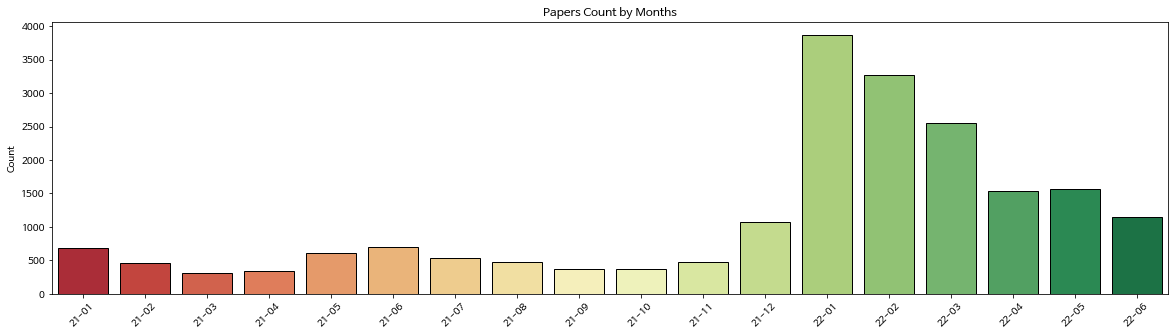

In [ ]:
# Paper count per Month-Weeks
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_per_day = news_df['Date'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name = 'counts')

# Plot
plt.figure(figsize = (20, 5))
ax = sns.barplot(x = 'index',
                 y = 'counts', 
                 data = news_per_day,
                 edgecolor = 'black',
                 ci = False, 
                 palette = 'RdYlGn')
plt.title('Papers Count by Months')
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation = 45)
plt.show()

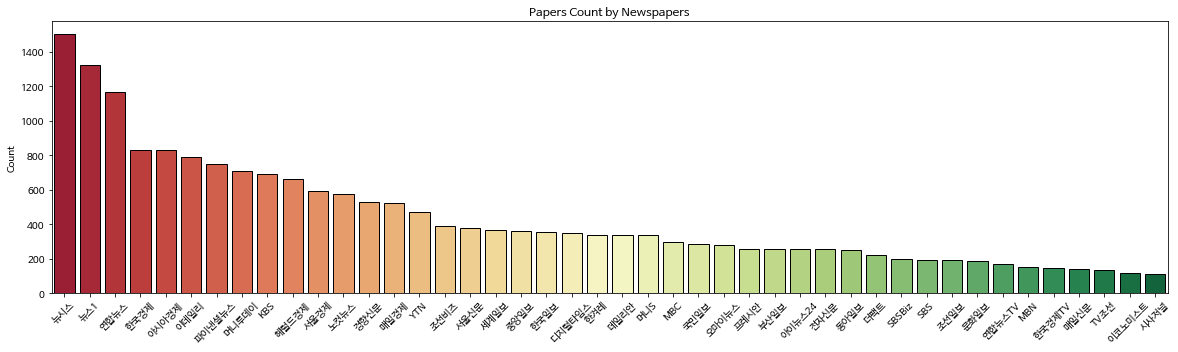

In [ ]:
news_per_paper = news_df['Paper'].value_counts().loc[lambda x : x > 100].reset_index(name = 'counts')
# Plot
plt.figure(figsize = (20, 5))
ax = sns.barplot(x = 'index',
                 y = 'counts', 
                 data = news_per_paper,
                 edgecolor = 'black',
                 ci = False, 
                 palette = 'RdYlGn')
plt.title('Papers Count by Newspapers')
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation = 45)
plt.show()

 
 ===== '중대재해처벌법' 관련 기사 토픽 및 키워드 Top 10 ===== 
 
>> Total number of topics : 940


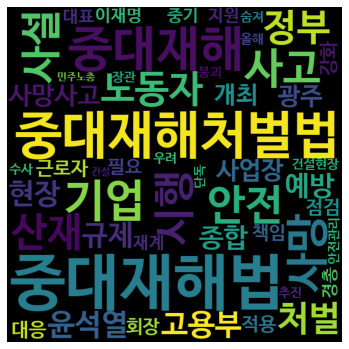

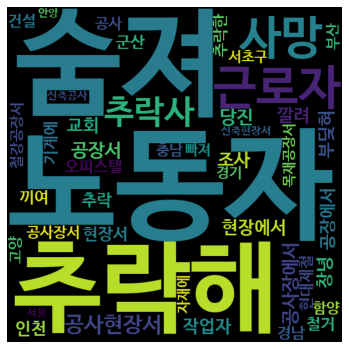

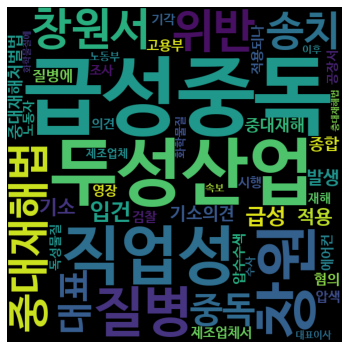

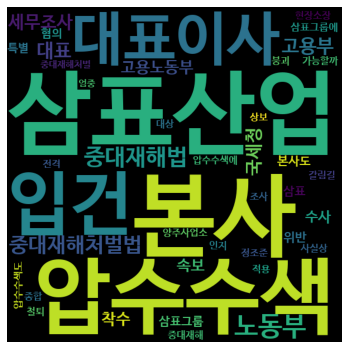

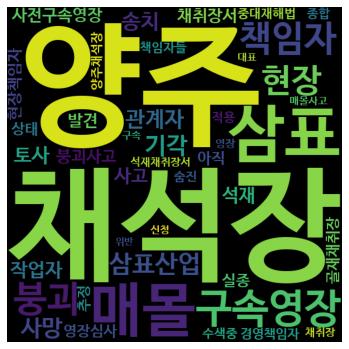

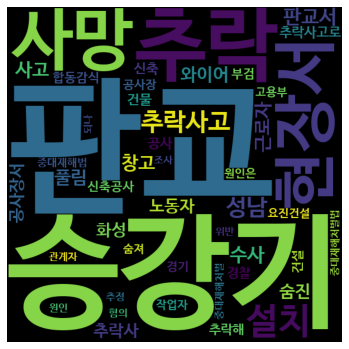

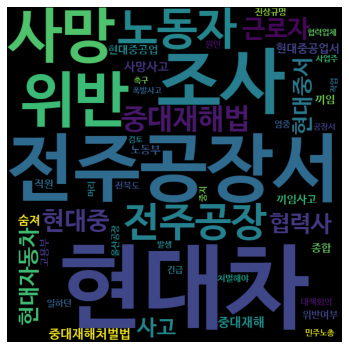

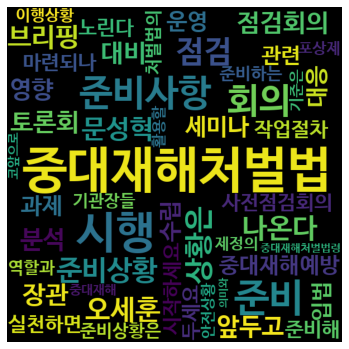

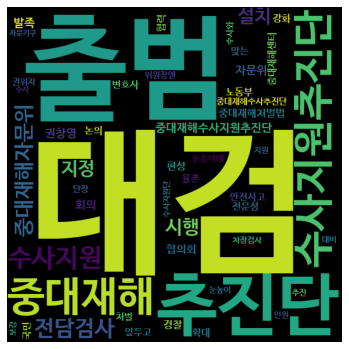

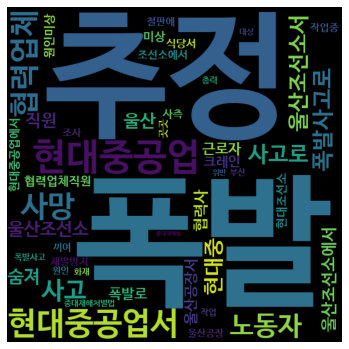

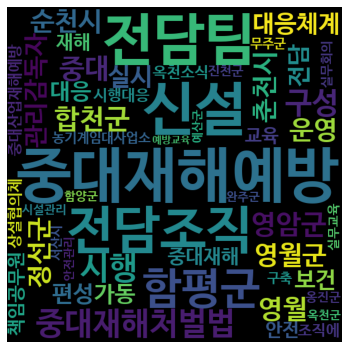

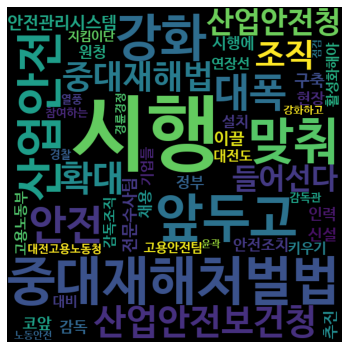

In [ ]:
news_keywords("중대재해처벌법", 10)